## List of Functions and imports

In [5]:
import sys
sys.path.append('/Applications/pygplates_rev18_python27_MacOS64')
import pygplates
print "Imported pygplates."
import shapefile
print "Imported shapefile."
import numpy
print "Imported numpy."
import math
print "Imported math"
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
print "imported matplotlib.pyplot"


%pylab inline 

ImportError: No module named pygplates

In [2]:
def readCSV(filename):
    '''
    Reads point data
    '''
    #lonMid, latMid, convRate, distance, \
    #orthAbs, orthOP, orthTrench,subObliquity,subPolarity,distEdge = \
    f=numpy.loadtxt(filename, delimiter=',')
    
    
    #return(lonMid, latMid, convRate, distance, \
    #orthAbs, orthOP, orthTrench,subObliquity,subPolarity,distEdge)
    return(f)

In [3]:
def latlon2pygplates(lat,lon):
    '''
    Convert lat lon to the pygplates formats
    '''
    pointLatLon = pygplates.LatLonPoint(lat,lon)
    pointXYZ = pygplates.convert_lat_lon_point_to_point_on_sphere(pointLatLon)
    pointXYZcart = numpy.array([pointXYZ.get_x(), pointXYZ.get_y(), pointXYZ.get_z()]) 
    
    return(pointXYZ,pointXYZcart)

In [4]:
def readTopologyPlatepolygonFile(filename,typeSLT):
    '''
    Reads shapefiles and returns the all the data fields
    '''
    shapeRead = shapefile.Reader(filename)

    recs    = shapeRead.records()
    shapes  = shapeRead.shapes()
    fields  = shapeRead.fields
    Nshp    = len(shapes)
    
    return(recs,shapes,fields,Nshp)

In [5]:
def getstrike(lon,lat,lon2,lat2):
    #Find the bearing of point 1 to point 2 (ALL IN RADIANS) from North
    #eqns from http://www.movable-type.co.uk/scripts/latlong.html
    radLat1 = numpy.radians(lat)
    radLat2 = numpy.radians(lat2)
    radLon1 = numpy.radians(lon)
    radLon2 = numpy.radians(lon2)
                            
    #θ = atan2( sin(Δλ).cos(φ2), cos(φ1).sin(φ2) − sin(φ1).cos(φ2).cos(Δλ) )
    bearingRad = numpy.arctan2( numpy.sin(radLon2-radLon1) * numpy.cos(radLat2),\
        numpy.cos(radLat1)*numpy.sin(radLat2) - \
        numpy.sin(radLat1)*numpy.cos(radLat2)*numpy.cos(radLon2-radLon1))

    return(bearingRad)

###This is the main function for getting the data from the ridge shapefile output

In [8]:
def ridgeLoop(recsRidge,shapesRidge,fieldsRidge,NshpRidge,time,plotme):
    '''
    Get the ridge stats by reading GPlates (resolved topology, citcoms) output.
    
    Input:
        Ridge transfroms data from GPlates resoolved topolgy (citcoms) shapefile
        Can be read with something like this:
    shapeRidge="topology_ridge_transform_boundaries_"+str(time)+".00Ma.shp"
    [recsRidge,shapesRidge,fieldsRidge,NshpRidge]=\
        readTopologyPlatepolygonFile(shapeRidge,'T')
        
    Execute by:
    ridgeData=ridgeLoop(recsRidge,shapesRidge,fieldsRidge,NshpRidge)
    
    Returns: (Python list)
        LengthOfRidge(km),time(Ma),SegmentNumber(arbitrary from input shapefile),
            TRENCHid(PlateID of feature),LengthOfTransforms(km)
         
    '''
    
    #Initiliase the array to store the data
    FinalArray=[]
    AngleArray=[]
    subArray=[]
    if plotme:
        fig = plt.figure(figsize=(12,8),dpi=150)
    
    #Count the number of ridges/transforms
    segNo=0

    #Go through ridges 1 by 1, as digitised in GPlates
    for nshpRidge in xrange(NshpRidge):

        #Check if it is a MOR
        for i in range(len(fieldsRidge)):
            if 'GPGIM_TYPE' in fieldsRidge[i]:
                TYPEIndex = i-1

        featureType=recsRidge[nshpRidge][TYPEIndex]

        #print featureType
        #If the feature type is a ridge (or whatever feature you want), continue
        if featureType=='gpml:MidOceanRidge':
            #Initialise some values
            distance = 0
            transform = 0
            
            #Increment the number of ridges/transforms
            segNo+=1
            
            #Get the Lat Lon points along the ridge
            shapeArray=shapesRidge[nshpRidge].points

            ##Get the plate ids etc
            for i in range(len(fieldsRidge)):
                if 'PLATE_ID' in fieldsRidge[i]:
                    TRENCHidIndex = i-1
    
            TRENCHid=recsRidge[nshpRidge][TRENCHidIndex]
                    
            #Get the general strike (bearing) of MOR, using the first and last points
            strike=getstrike(shapeArray[0][0],shapeArray[0][1],shapeArray[-1][0],\
                             shapeArray[-1][1])
                
            #Sum up the distances of each line segment
            for index, point in enumerate(shapeArray):
                #If we are past the first point on the ridge
                if index > 1:
                    #Convert point pairs to pygplates format
                    pointXYZ, pointXYZcart = latlon2pygplates(shapeArray[index-1][1],\
                                                              shapeArray[index-1][0])
                    pointXYZ2, pointXYZcart2 = latlon2pygplates(shapeArray[index][1],\
                                                                shapeArray[index][0])
    
                    #Get the bearing of these two points
                    angle=getstrike(shapeArray[index-1][0],shapeArray[index-1][1],\
                                    shapeArray[index][0],shapeArray[index][1])

                    Rearth=6371.0 # Radius of Earth in km
                    line = pygplates.PolylineOnSphere([pointXYZ,pointXYZ2])
                    
                    
                    # refangle to indentify the MOR and the transform
                    #refangle = 0.9

                    
                    # Use 45 degrees as the critical angle (0.78 radians) to check if Ridge
                    if abs(strike - angle) < 1.3:
                        #Caluclate the distance of the point pair
                        distance += line.get_arc_length() * Rearth
                        
                        #Store the obliquity of the ridge also
                        AngleArray.append([shapeArray[index-1][0],shapeArray[index-1][1],\
                                           angle,strike,segNo,time])
                        
                        #Plot the MOR 
                        if plotme:
                            p1,=plt.plot([shapeArray[index-1][0],shapeArray[index][0]] ,\
                                [shapeArray[index-1][1],shapeArray[index][1]],'b-',label='ridge')

                        #Now I am going to update the strike here  in case the 
                        #MOR changes direction slightly.
                        strike=angle 
                        
                    else:
                        transform += line.get_arc_length() * Rearth
                        
                        #Plot the transform
                        if plotme:
                            p2,=plt.plot([shapeArray[index-1][0],shapeArray[index][0]] ,\
                                [shapeArray[index-1][1],shapeArray[index][1]],'r-',label='transform')

            FinalArray.append([distance,time,segNo,TRENCHid,transform])
         
                
        else:
            pass
    if plotme:
        plt.legend([p1, p2], ["ridge", "transform"])
        plt.show()
    return (FinalArray,AngleArray,subArray)




##Here begins the interactive part. Set the time and make some plots

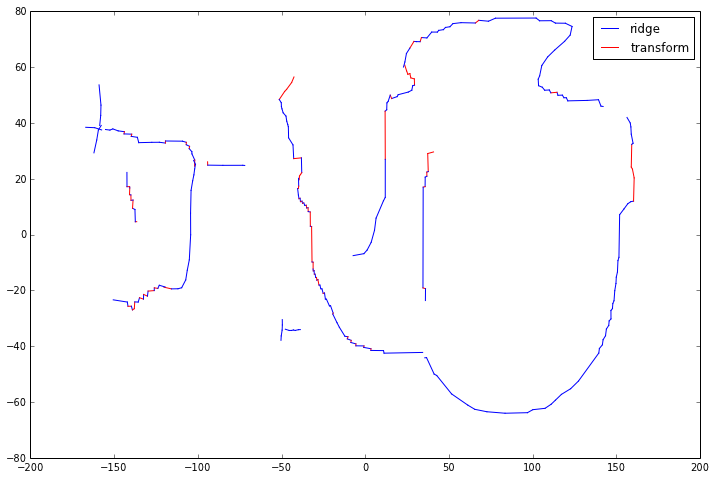

ValueError: too many values to unpack

In [17]:
time=0
shapeRidge="/Users/mallardclaire/Data/ProjetSydney2014/Ridges/reconstructed_"+str(time)+".00Ma.shp"
[recsRidge,shapesRidge,fieldsRidge,NshpRidge]=readTopologyPlatepolygonFile(shapeRidge,'T')
[ridgeData,angleData]=ridgeLoop(recsRidge,shapesRidge,fieldsRidge,NshpRidge,time,1)

f=numpy.array(ridgeData)
g=numpy.array(angleData)

longs=g[:,0]
lats=g[:,1]
segs=g[:,4]
angle=g[:,2]*180.0/3.14
strike=g[:,3]*180.0/3.14

In [15]:

time=0
subArray=[0]
while time<=16:
    shapeRidge="/Users/mallardclaire/Data/ProjetSydney2014/Ridges/reconstructed_"+str(time)+".00Ma.shp"
    [recsRidge,shapesRidge,fieldsRidge,NshpRidge]=readTopologyPlatepolygonFile(shapeRidge,'T')
    [ridgeData,angleData]=ridgeLoop(recsRidge,shapesRidge,fieldsRidge,NshpRidge,time,0)

    f=numpy.array(ridgeData)
    g=numpy.array(angleData)
    #h=numpy.array(subData)

    longs=g[:,0]
    lats=g[:,1]
    segs=g[:,4]
    angle=g[:,2]*180.0/3.14
    strike=g[:,3]*180.0/3.14
  
    time+=1
    


ValueError: too many values to unpack

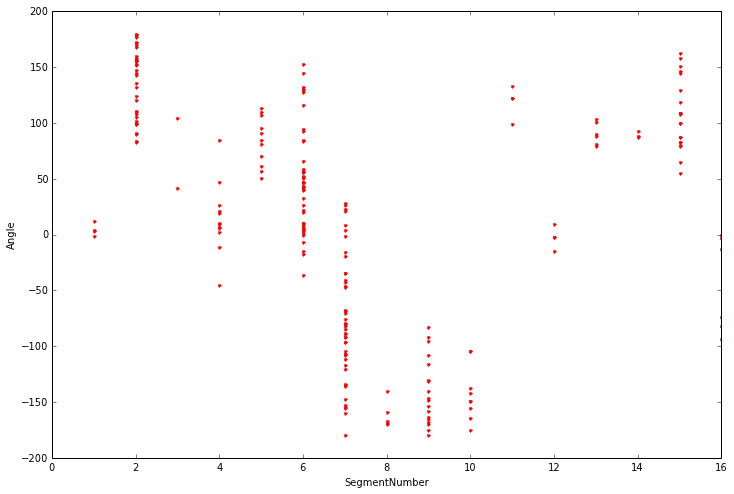

In [18]:
# figure shows number of segment in fonction of angle value.

fig = plt.figure(figsize=(12,8),dpi=150)
plt.plot(segs,angle,'r.')
plt.xlabel('SegmentNumber')
plt.ylabel('Angle')
plt.show()

print refangle

print refangle*180/3.14

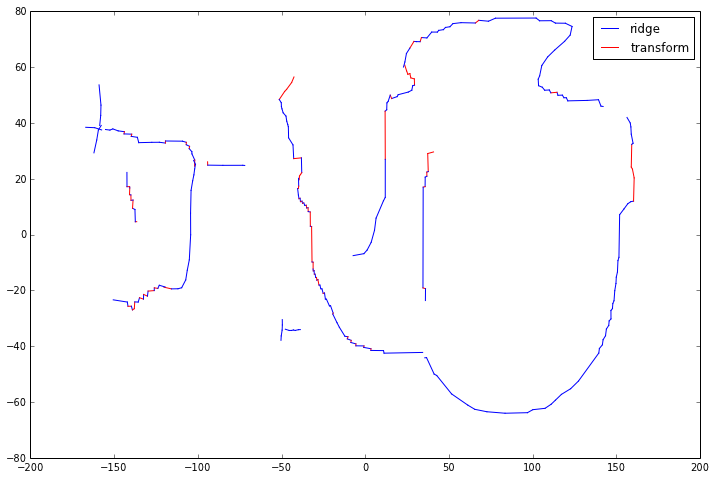

ValueError: too many values to unpack

In [11]:
time=0
shapeRidge="/Users/mallardclaire/Data/ProjetSydney2014/Ridges/reconstructed_"+str(time)+".00Ma.shp"
[recsRidge,shapesRidge,fieldsRidge,NshpRidge]=readTopologyPlatepolygonFile(shapeRidge,'T')
[ridgeData,angleData]=ridgeLoop(recsRidge,shapesRidge,fieldsRidge,NshpRidge,time,1)


print refangle
print refangle*180/3.14

f=numpy.array(ridgeData)
g=numpy.array(angleData)

longs=g[:,0]
lats=g[:,1]
segs=g[:,4]
angle=g[:,2]*180/3.14
strike=g[:,3]*180/3.14

In [19]:
def cmap_discretize(cmap, N):
    #http://wiki.scipy.org/Cookbook/Matplotlib/ColormapTransformations
    """Return a discrete colormap from the continuous colormap cmap.     
    cmap: colormap instance, eg. cm.jet. 
    N: number of colors.
    
    Example
    x = resize(arange(100), (5,100))
    djet = cmap_discretize(cm.jet, 5)
    imshow(x, cmap=djet)
    """
    import matplotlib
    
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in xrange(N+1) ]
    
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [20]:
'''
Make your own colormap!
This is a double-cylic map, so that Both ends and the middle are the same color
Inspired by http://stackoverflow.com/a/11659600
'''
import matplotlib.colors as mcolors

levs = range(90)
assert len(levs) % 2 == 0, 'N levels must be even.'

wrap_cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(1, 0, 0),
                                                          (1, 1, 0),
                                                          (0, 1, 1),                      
                                                          (0, 0, 1),
                                                          (0, 1, 1),
                                                          (1, 1, 0),
                                                          (1, 0, 0),
                                                          (1, 1, 0),
                                                          (0, 1, 1),
                                                          (0, 0, 1),
                                                          (0, 1, 1),
                                                          (1, 1, 0),
                                                          (1, 0, 0),],N=len(levs)-1,)
                                                 

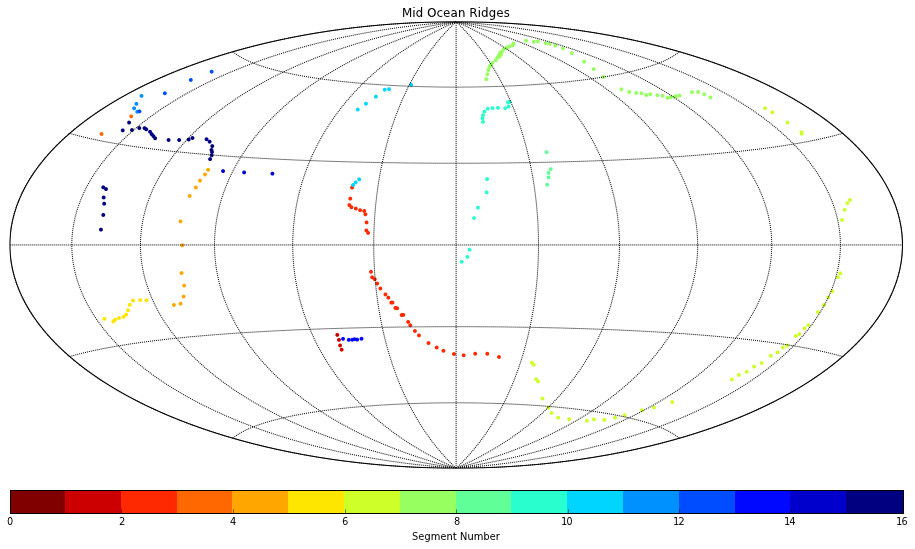

In [21]:
#Plot the segments as defined in the GPlates output
#NOTE: some segments are missing, because they were not gpml:MidOceanRidge features!

fig = plt.figure(figsize=(16,12),dpi=150)
cm = cmap_discretize(plt.cm.jet_r, int(max(segs)))

pmap = Basemap(projection='hammer', lat_0=0, lon_0=0,
           resolution='l')
#pmap.drawmapboundary(fill_color='white')
#la ligne du dessous permet de visualiser les continents
#pmap.fillcontinents(color='grey', lake_color='white', zorder=0)
pmap.drawmeridians(numpy.arange(0, 360, 30))
pmap.drawparallels(numpy.arange(-90, 90, 30))

xh, yh = pmap(longs, lats)
l1 = pmap.scatter(xh, yh, 15, marker='o', c=segs,
              edgecolor='none', vmin=0, vmax=max(segs),cmap=cm)
cbar=pmap.colorbar(l1,location='bottom',pad="5%")
cbar.set_label('Segment Number')
plt.title('Mid Ocean Ridges')
plt.show()

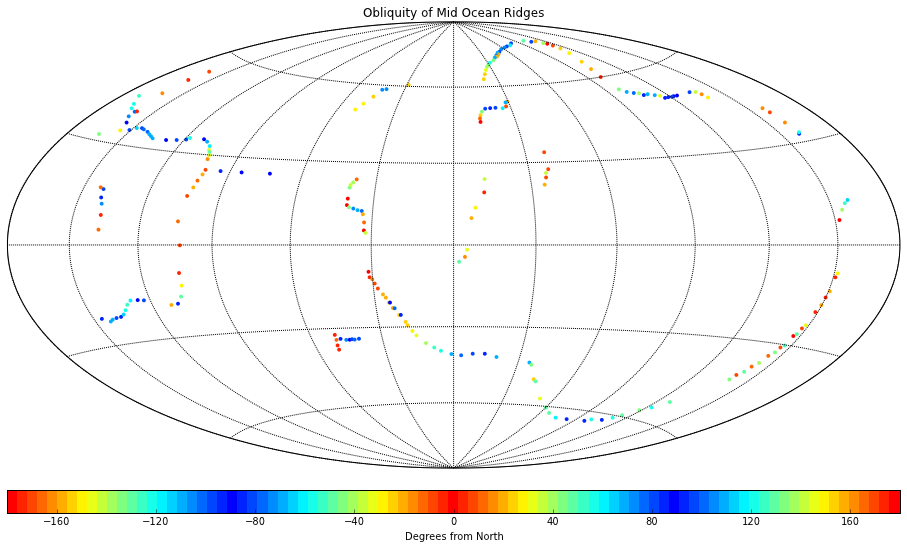

In [22]:
#Plot le degré d'obliquité des MOR par rapport au nord
#Plot the stike of each point pair

fig = plt.figure(figsize=(16,12),dpi=150)

pmap = Basemap(projection='hammer', lat_0=0, lon_0=0,
           resolution='l')
pmap.drawmapboundary(fill_color='white')
#pmap.fillcontinents(color='grey', lake_color='white', zorder=0)
pmap.drawmeridians(numpy.arange(0, 360, 30))
pmap.drawparallels(numpy.arange(-90, 90, 30))

xh, yh = pmap(longs, lats)
l1 = pmap.scatter(xh, yh, 15, marker='o', c=strike, cmap=wrap_cmap,
              edgecolor='none', vmin=-180, vmax=180)
cbar=pmap.colorbar(l1,location='bottom',pad="5%")
cbar.set_label('Degrees from North')
plt.title('Obliquity of Mid Ocean Ridges')
plt.show()

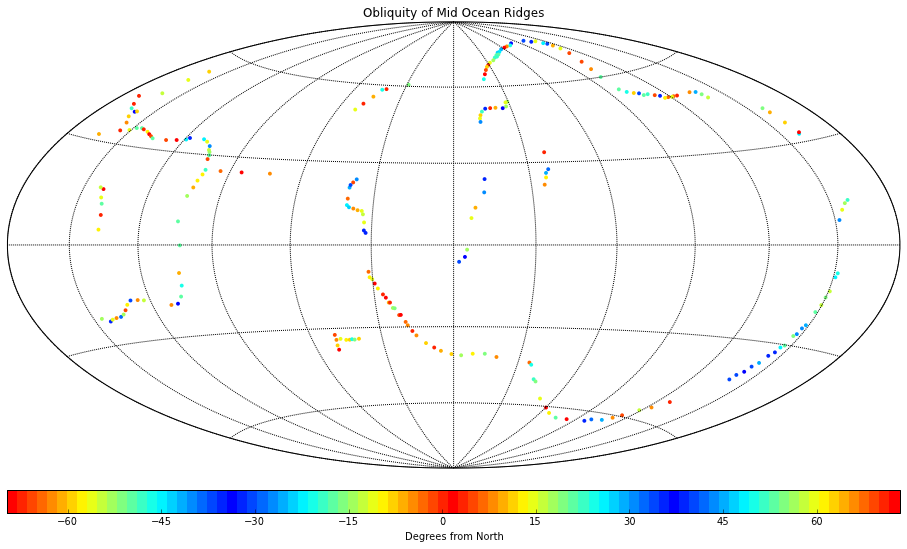

In [23]:
#Plot le degré d'obliquité des segments (deux points) des MOR par rapport au nord
#Plot the stike of each point pair

fig = plt.figure(figsize=(16,12),dpi=150)

pmap = Basemap(projection='hammer', lat_0=0, lon_0=0,
           resolution='l')
pmap.drawmapboundary(fill_color='white')
#pmap.fillcontinents(color='grey', lake_color='white', zorder=0)
pmap.drawmeridians(numpy.arange(0, 360, 30))
pmap.drawparallels(numpy.arange(-90, 90, 30))

xh, yh = pmap(longs, lats)
l1 = pmap.scatter(xh, yh, 15, marker='o', c=strike-angle,cmap=wrap_cmap,
              edgecolor='none')
cbar=pmap.colorbar(l1,location='bottom',pad="5%")
cbar.set_label('Degrees from North')
plt.title('Obliquity of Mid Ocean Ridges')
plt.show()

0


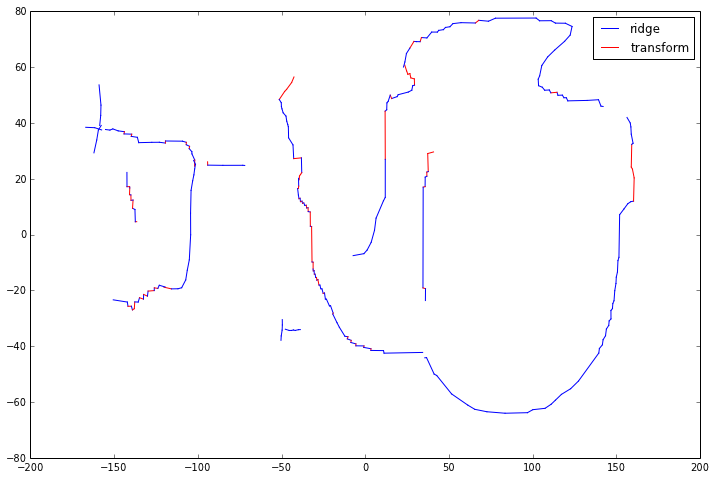

ValueError: too many values to unpack

In [25]:
# Donne longueur totale  et nombre de MOR par Ma

ridgeArray=[]
for time in xrange(0,16,1):
    print time
    shapeRidge="/Users/mallardclaire/Data/ProjetSydney2014/Ridges/reconstructed_"+str(time)+".00Ma.shp"
    [recsRidge,shapesRidge,fieldsRidge,NshpRidge]=readTopologyPlatepolygonFile(shapeRidge,'T')
    [ridgeData,angleData]=ridgeLoop(recsRidge,shapesRidge,fieldsRidge,NshpRidge,time,1)

    totalRidgeSum=numpy.sum(ridgeData,0)[0]
    numberOfRidges=ridgeData[-1][2]
    print totalRidgeSum, numberOfRidges
    ridgeArray.append([totalRidgeSum,numberOfRidges])
    f=numpy.array(ridgeData)

      

[[  8.32652021e+02   1.60000000e+01   1.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.15888977e+04   1.60000000e+01   2.00000000e+00   0.00000000e+00
    4.79276644e+02]
 [  5.58130575e+02   1.60000000e+01   3.00000000e+00   0.00000000e+00
    7.64100437e+02]
 [  5.71817890e+03   1.60000000e+01   4.00000000e+00   0.00000000e+00
    8.60971293e+02]
 [  2.92169433e+03   1.60000000e+01   5.00000000e+00   0.00000000e+00
    1.38350544e+02]
 [  1.64094660e+04   1.60000000e+01   6.00000000e+00   0.00000000e+00
    2.27086760e+03]
 [  9.38602360e+03   1.60000000e+01   7.00000000e+00   0.00000000e+00
    1.33875858e+02]
 [  1.10079567e+03   1.60000000e+01   8.00000000e+00   0.00000000e+00
    5.41951782e+03]
 [  5.51661481e+03   1.60000000e+01   9.00000000e+00   0.00000000e+00
    4.24492730e+03]
 [  2.62897576e+03   1.60000000e+01   1.00000000e+01   0.00000000e+00
    3.42656160e+03]
 [  1.35163155e+03   1.60000000e+01   1.10000000e+01   0.00000000e+00
    0.00000000e+00]
 [  1.7944

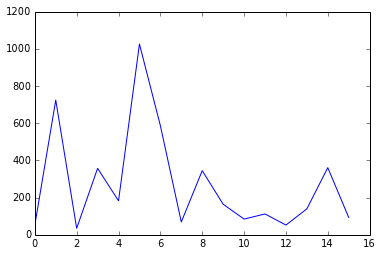

In [26]:
g=numpy.array(ridgeData)

print g 

plt.plot(g[:,0]/g[:,1])



In [28]:
# Nombre de transformantes en fonction de la longueur de transformantes.
# Nombre de MOR en fonction sur 200Ma pour MOR shorter than 1000km through time
# Nombre de MOR en fonction de la longueur de MOR

fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig, ax = plt.subplots() #Order of these determines the rotation after the loop, i.e. first call to plt.
time = 0

#while time <=16:
    #print time
#for time in xrange(0,16,1):
for time = 1 : 
    print time
    ShapeRidge="/Users/mallardclaire/Data/ProjetSydney2014/Ridges/reconstructed_"+str(time)+".00Ma.shp"
    [recsRidge,shapesRidge,fieldsRidge,NshpRidge]=readTopologyPlatepolygonFile(shapeRidge,'T')
    [ridgeData,angleData]=ridgeLoop(recsRidge,shapesRidge,fieldsRidge,NshpRidge,time,0)

    f=numpy.array(ridgeData)

    #length of transforms
    hist2, bins2 = numpy.histogram(f[:,4], bins=10, range=(0,2500))
    width2=0.2*(bins2[1]-bins2[0])
    center2=(bins2[:-1] + bins2[1:]) / 2

    print hist2, bins2
    
    rects2=ax2.bar(center2+time*1.0-100.0,hist2,align='center',width=width2,\
        edgecolor=[(time+0.1)/100.0,(time+0.1)/100.0,(time+0.1)/100.0],\
        color=[(time+0.1)/400.0,(time+0.1)/400.0,(time+0.1)/400.0])   
        
    #Zoom in on Ridges
    hist3, bins3 = numpy.histogram(f[:,0], bins=1, range=(0,1000))
    width3=0.01*(bins3[1]-bins3[0])
    center3=(bins3[:-1] + bins3[1:]) / 2

    rects3=ax3.bar(center3+time*4.6-450.0,hist3,align='center',width=width3,\
        edgecolor=[(time+0.1)/16,1-(time+0.1)/16,(time+0.1)/16],\
        color=[(time+0.1)/16,1-(time+0.1)/16,(time+0.1)/16])
        
    #Length of ridges
    hist, bins = numpy.histogram(f[:,0], bins=13, range=(0,13000))
    width=0.01*(bins[1]-bins[0])
    center=(bins[:-1] + bins[1:]) / 2

    rects1=ax.bar(center+time*4.0-350.0,hist,align='center',width=width,\
        edgecolor=[(time+0.1)/16,1-(time+0.1)/16,(time+0.1)/16],\
        color=[(time+0.1)/16,1-(time+0.1)/16,(time+0.1)/16])  
    
    
ax2.set_xlabel('Length of transforms along MOR (km)')
ax2.set_ylabel('Number of transforms along MOR')
ax2.set_xticks(numpy.round(bins2[0:-1]))
plt.xticks(rotation=45)

ax3.set_xlabel('Mid Ocean Ridges shorter than 1000 km through time')
ax3.set_ylabel('Number of ridges')
ax3.set_xticks([0,1000])
ax3.set_xticklabels(['0 Ma','200 Ma'])

ax.set_xlabel('Length of ridges (km)')
ax.set_ylabel('Number of ridges')
ax.set_xticks(numpy.round(bins[0:-1]))
plt.xticks(rotation=45)

plt.show() 
#time += 1



SyntaxError: invalid syntax (<ipython-input-28-7a1ffaecb88d>, line 13)

In [29]:
#time=0
#shapeRidge="/Users/mallardclaire/Documents/plates/topology_"+str(time)+".00Ma.shp"
#[recsRidge,shapesRidge,fieldsRidge,NshpRidge]=readTopologyPlatepolygonFile(shapeRidge,'T')

In [30]:
time=0
shapeRidge="/Users/mallardclaire/Data/ProjetSydney/Plates/topology_"+str(time)+".00Ma.shp"
[recsRidge,shapesRidge,fieldsRidge,NshpRidge]=readTopologyPlatepolygonFile(shapeRidge,'T')

#make a blank variable for storing numbers
polyArray=[]
#Loop through each polygon
for nshpRidge in xrange(NshpRidge): 
    
    shapeArray=shapesRidge[nshpRidge].points
    pointArray=[]
    for point in shapeArray:
        pointXYZ, pointXYZcart = latlon2pygplates(point[1],point[0])
        pointArray.append(pointXYZ)
        
    polygon=pygplates.PolygonOnSphere(pointArray)
    polyArray.append(polygon.get_area() * 6371 * 6371)
    
    #rajouter le nom de chaque plaque
    print 'A', time,'My, Area of plate ' ,nshpRidge, ':' , polygon.get_area() * 6371 * 6371
#somme des airs des plaques
print 'A', time, 'My, Total Area of Plates: ', sum(polyArray)


ShapefileException: Unable to open /Users/mallardclaire/Data/ProjetSydney/Plates/topology_0.00Ma.shp

In [ ]:
print recsRidge[1][1]
print fieldsRidge[1]
#print fieldsRidge[4]

In [ ]:
import math

time=0
while time<=16:
    shapeRidge="/Users/mallardclaire/Data/Plates/topology_"+str(time)+".00Ma.shp"
    [recsRidge,shapesRidge,fieldsRidge,NshpRidge]=readTopologyPlatepolygonFile(shapeRidge,'T')
    #make a blank variable for storing numbers
    polyArray=[]
    #Loop through each polygon
    for nshpRidge in xrange(NshpRidge): 
    
        shapeArray=shapesRidge[nshpRidge].points
        pointArray=[]
        for point in shapeArray:
            pointXYZ, pointXYZcart = latlon2pygplates(point[1],point[0])
            pointArray.append(pointXYZ)
        
        polygon=pygplates.PolygonOnSphere(pointArray)
        plateArea=polygon.get_area() * 6371 * 6371
        polyArray.append(plateArea)
        logArea=math.log10(plateArea)

    
    
        #rajouter le nom de chaque plaque
        print 'plate_ID : ', recsRidge[nshpRidge][3],'Area : ', polygon.get_area() * 6371 * 6371, 'logArea:',logArea 
    hist, bins = numpy.histogram(polyArray, bins=10)
    width = 0.7*(bins[1]-bins[0])
    center = (bins[:-1]+bins[1:])/2
    plt.bar(center, hist, align='center', width = width)
    plt.show()
    
    #somme des airs des plaques
    print 'A', time, 'My, Total Area of Plates: ', sum(polyArray)
    time=time+1

In [ ]:
#Plot the segments as defined in the GPlates output
#NOTE: some segments are missing, because they were not gpml:MidOceanRidge features!

fig = plt.figure(figsize=(16,12),dpi=150)
cm = cmap_discretize(plt.cm.jet_r, int(max(segs)))

pmap = Basemap(projection='hammer', lat_0=0, lon_0=0,
           resolution='l')
pmap.drawmapboundary(fill_color='white')
#pmap.fillcontinents(color='grey', lake_color='white', zorder=0)
pmap.drawmeridians(numpy.arange(0, 360, 30))
pmap.drawparallels(numpy.arange(-90, 90, 30))

xh, yh = pmap(longs, lats)
l1 = pmap.scatter(xh, yh, 15, marker='o', c=segs,
              edgecolor='none', vmin=0, vmax=max(segs),cmap=cm)
cbar=pmap.colorbar(l1,location='bottom',pad="5%")
cbar.set_label('Plates Number')
plt.title('Plates')
plt.show()